___

- Dans ce notebook on vous propose deux source de prévision de production éolienne (FOR_D, FOR_M) ainsi que la production réalisée d'un parc éolien en France.
- Il s'agit uniquement des prévisions D+1 ( Horizon de prévision entre 24 et 48 heures). Les prévisions du jour J on été générées le jour J-1 à 00:00.
- Lien cas d'usage: Pour les programmes d'appel ( marché SPOT Day Ahead) il faut fournir la prévision de production la veille avant midi pour le lendemain.

- Attention : Seulement 5 mois des données, données incomplètes ( sousperformance, arrêt parc etc.)


Objectif: 
Mettre en place une méthode qui permet d'agréger différents experts au fil de l'eau sans créer un novueau modèle de prévisions et qui est capable de s'adapter automatiquement aux changement du context (météo,saison, sous-performance, amélioration d'un expert etc.)


___

In [6]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.graphics.tsaplots import plot_acf


In [7]:
df = pd.read_csv('FRMIR_v1.csv',sep=';',parse_dates=['DateTime'],dayfirst=True)

In [8]:
df['Dates'] = df['DateTime'].dt.day_name() 
df['Time'] = df['DateTime'].dt.time

In [9]:
df

,DateTime,FOR_D,FOR_M,Power,Dates,Time
0,2020-03-05 00:00:00,1561.546745,14654.2,2398.581163,Thursday,00:00:00
1,2020-03-05 01:00:00,1308.262362,3982.0,2327.819766,Thursday,01:00:00
2,2020-03-05 02:00:00,1190.923118,3625.6,1587.336721,Thursday,02:00:00
3,2020-03-05 03:00:00,1697.768798,3269.2,1439.571654,Thursday,03:00:00
4,2020-03-05 04:00:00,1989.946882,3091.0,1375.600484,Thursday,04:00:00
...,...,...,...,...,...,...
2537,2020-07-24 22:00:00,378.737301,2734.6,1161.229859,Friday,22:00:00
2538,2020-07-24 23:00:00,611.716664,2080.1,1239.117910,Friday,23:00:00
2539,2020-07-25 00:00:00,614.771268,2378.2,1613.549091,Saturday,00:00:00
2540,2020-07-25 01:00:00,511.514462,2734.6,2200.139987,Saturday,01:00:00


In [10]:
df['Power']

0       2398.581163
1       2327.819766
2       1587.336721
3       1439.571654
4       1375.600484
           ...     
2537    1161.229859
2538    1239.117910
2539    1613.549091
2540    2200.139987
2541    2487.865467
Name: Power, Length: 2542, dtype: float64

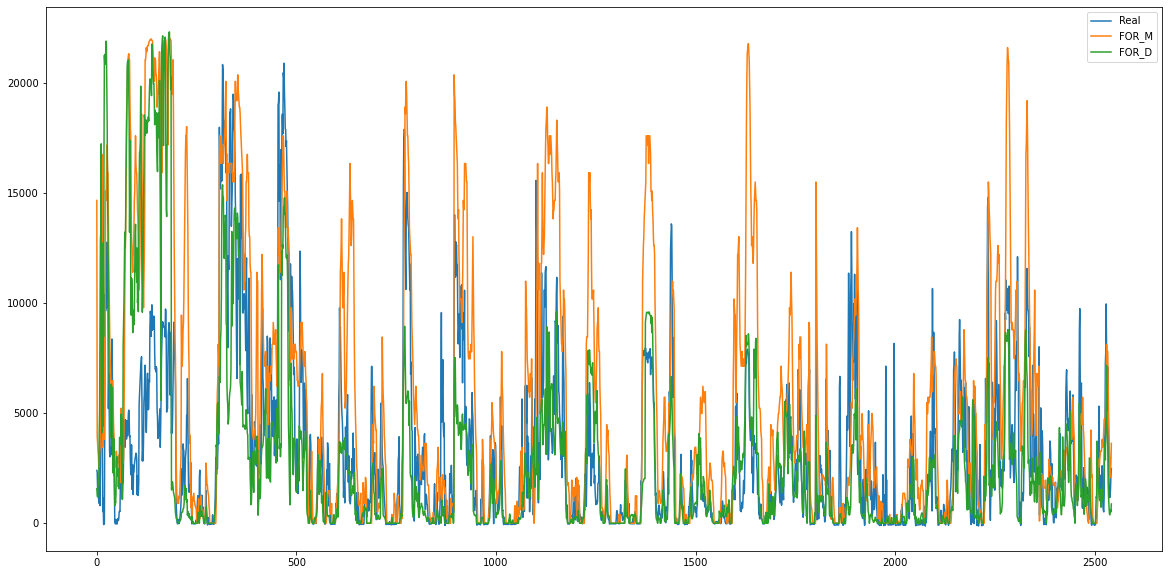

In [11]:
# Day+1
plt.figure(figsize=(20,10))


plt.plot(df['Power'],label='Real')
plt.plot(df['FOR_M'],label='FOR_M')
plt.plot(df['FOR_D'],label='FOR_D')
plt.legend()

----

In [12]:
import numpy as np

# Cette section regroupe des fonction de métrique d'erreurs

In [28]:
# Mean absoolute error (MAE)

def MAE(Y, Y_chap):
    if len(Y) == len(Y_chap):
        mae = np.sum(np.absolute(Y_chap - Y)) / len(Y)
    else:
        print('Probleme de dimension entre Y et Y_chap')
        print('len(Y) :', len(Y))
        print('len(Y_chap) :', len(Y_chap))
    
    return -mae

# Mean absolute percentage error (MAPE)

def MAPE(Y, Y_chap):
    if len(Y) == len(Y_chap):
        AF = (Y - Y_chap)
        for i in range(len(Y)):
            AF[i] = (AF[i] / Y[i])
        mape = np.absolute(100*AF).mean() 
    else:
        print('Probleme de dimension entre Y et Y_chap')
        print('len(Y) :', len(Y))
        print('len(Y_chap) :', len(Y_chap))

    return mape


# Root Mean squared error (MRSE)

def MRSE(Y, Y_chap):
    if len(Y) == len(Y_chap):
        mrse = np.sqrt(((Y_chap - Y)**2).mean()) 
    else:
        print('Probleme de dimension entre Y et Y_chap')
        print('len(Y) :', len(Y))
        print('len(Y_chap) :', len(Y_chap))
    
    return -mrse

In [29]:
new_agent = 0.5*df['FOR_D'] + 0.5*df['FOR_M']

___

## Bayesian Opti

In [30]:
from bayes_opt import BayesianOptimization

In [46]:
# Let's start by definying our function, bounds, and instanciating an optimization object.
def black_box_function(x, y, z):
    a = x * df['FOR_D'] + y * df['FOR_M'] + z * new_agent
    return MRSE(df['Power'], a)

In [47]:
# Bounded region of parameter space
pbounds = {'x': (0.0001, 1), 'y': (0.0001, 1),  'z': (0.0001, 1)}

In [48]:
optimizer = BayesianOptimization(
    f=black_box_function,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)

In [49]:
optimizer.maximize(
    init_points=1,
    n_iter=50,
    acq="ei", 
    xi=1e-4
)

|   iter    |  target   |     x     |     y     |     z     |
-------------------------------------------------------------
|  1        | -4.541e+0 |  0.4171   |  0.7204   |  0.000214 |
|  2        | -7.948e+0 |  1.0      |  0.0001   |  1.0      |
|  3        | -6.459e+0 |  0.5323   |  0.7874   |  0.175    |
|  4        | -6.348e+0 |  0.5959   |  0.2611   |  0.7468   |
|  5        | -5.12e+03 |  0.2276   |  0.1557   |  0.9473   |
|  6        | -7.025e+0 |  0.7263   |  0.7286   |  0.1948   |
|  7        | -4.709e+0 |  0.4471   |  0.7257   |  0.003172 |
|  8        | -5.128e+0 |  0.2437   |  0.1402   |  0.9544   |
|  9        | -1.158e+0 |  0.4888   |  0.8412   |  0.9791   |
|  10       | -2.762e+0 |  0.174    |  0.388    |  0.0001   |
|  11       | -4.308e+0 |  0.0001   |  0.0001   |  0.1461   |
|  12       | -2.773e+0 |  0.0001   |  0.473    |  0.0001   |
|  13       | -3.451e+0 |  0.6042   |  0.0001   |  0.0001   |
|  14       | -2.925e+0 |  0.3372   |  0.2394   |  0.0001   |
|  15   

In [50]:
print(optimizer.max)

{'target': -2739.265133153745, 'params': {'x': 0.06339024315120337, 'y': 0.4287348471311386, 'z': 0.06619468852786363}}


In [51]:
optimizer.max['params']

{'x': 0.06339024315120337, 'y': 0.4287348471311386, 'z': 0.06619468852786363}

In [167]:
print(b)

0       6006.905899
1       1768.389404
2       1610.075760
3       1547.886595
4       1522.760320
           ...     
2537    1134.390644
2538     912.723716
2539    1030.496475
2540    1154.838327
2541    1561.306964
Length: 2542, dtype: float64


In [55]:
def dist_eucl(value1, value2):
    return np.sqrt((value1 - value2)**2) /  (value1 + value2)

In [56]:
def dist_abs(value1, value2):
    return np.absolute((value1 - value2)) 

In [57]:
'''x = x/(x+y+z)
y = y/(x+y+z)
z = z/(x+y+z)'''

'x = x/(x+y+z)\ny = y/(x+y+z)\nz = z/(x+y+z)'

In [58]:
x =  0.06339024315120337
y =  0.4287348471311386
z = 0.0661012986577294

In [59]:
b = df['FOR_D'] * x + df['FOR_M'] * y + new_agent * z

In [60]:
dist_eucl(value1 = df['FOR_M'], value2 = df['Power'][2000:]).mean()

0.43850329647505787

In [61]:
dist_abs(value1 = b[2000:], value2 =df['Power'][2000:]).mean()

1420.0497930632368

In [62]:
dist_abs(value1 = df['FOR_M'][2000:], value2 = df['Power'][2000:]).mean()

2274.89062795686

In [68]:
dist_abs(value1 = df['FOR_D'][2000:], value2 = df['Power'][2000:]).mean()

1414.2235979362

In [63]:
dist_abs(value1 = new_agent[2000:], value2 = df['Power'][2000:]).mean()

1403.6374458340435

In [64]:
MRSE(b[2000:],df['Power'][2000:])

-2043.2576338210285

In [65]:
MRSE(new_agent[2000:],df['Power'][2000:])

-1921.0847529917703

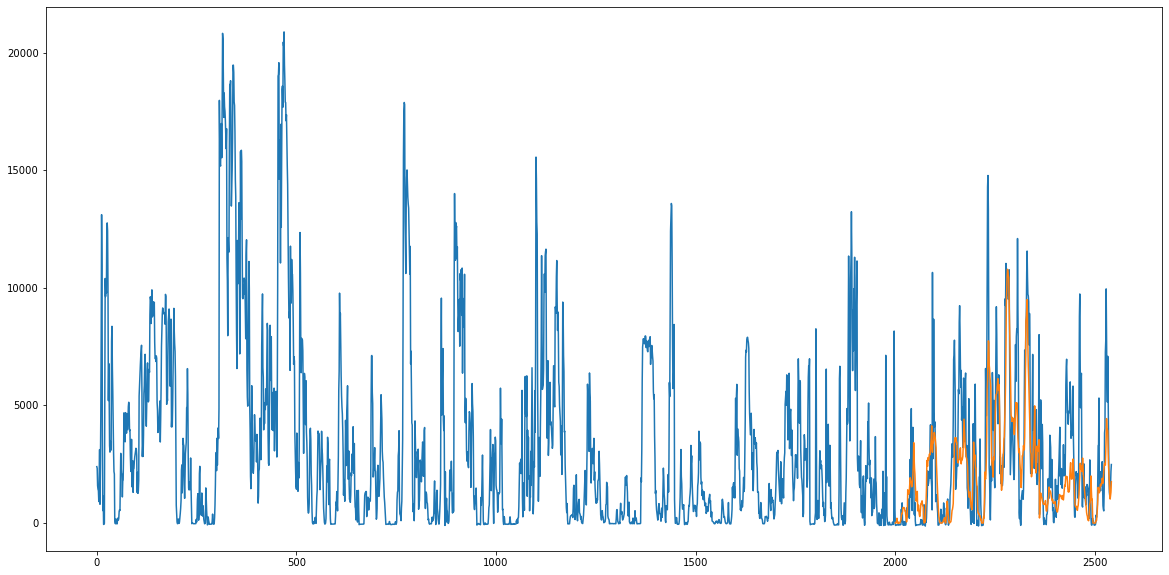

In [66]:
plt.figure(figsize=(20,10))
plt.plot(df['Power'])
#plt.plot(df['FOR_M'][2000:])
#plt.plot(new_agent)
plt.plot(b[2000:])


___

##  Learn Bayesian Optimization

Optima: x=0.900, y=0.810


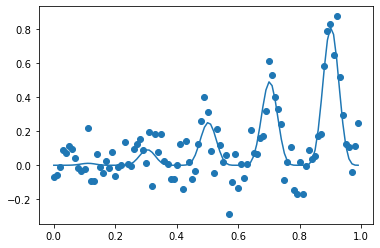

In [2]:
# example of the test problem
from math import sin
from math import pi
from numpy import arange
from numpy import argmax
from numpy.random import normal
from matplotlib import pyplot

# objective function
def objective(x, noise=0.1):
	noise = normal(loc=0, scale=noise)
	return (x**2 * sin(5 * pi * x)**6.0) + noise

# grid-based sample of the domain [0,1]
X = arange(0, 1, 0.01)
# sample the domain without noise
y = [objective(x, 0) for x in X]
# sample the domain with noise
ynoise = [objective(x) for x in X]
# find best result
ix = argmax(y)
print('Optima: x=%.3f, y=%.3f' % (X[ix], y[ix]))
# plot the points with noise
pyplot.scatter(X, ynoise)
# plot the points without noise
pyplot.plot(X, y)
# show the plot
pyplot.show()

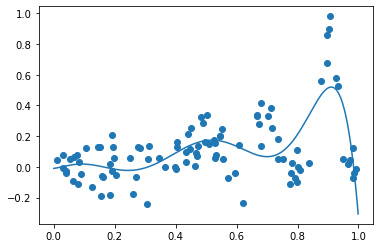

In [3]:
# example of a gaussian process surrogate function
from math import sin
from math import pi
from numpy import arange
from numpy import asarray
from numpy.random import normal
from numpy.random import random
from matplotlib import pyplot
from warnings import catch_warnings
from warnings import simplefilter
from sklearn.gaussian_process import GaussianProcessRegressor

# objective function
def objective(x, noise=0.1):
	noise = normal(loc=0, scale=noise)
	return (x**2 * sin(5 * pi * x)**6.0) + noise

# surrogate or approximation for the objective function
def surrogate(model, X):
	# catch any warning generated when making a prediction
	with catch_warnings():
		# ignore generated warnings
		simplefilter("ignore")
		return model.predict(X, return_std=True)

# plot real observations vs surrogate function
def plot(X, y, model):
	# scatter plot of inputs and real objective function
	pyplot.scatter(X, y)
	# line plot of surrogate function across domain
	Xsamples = asarray(arange(0, 1, 0.001))
	Xsamples = Xsamples.reshape(len(Xsamples), 1)
	ysamples, _ = surrogate(model, Xsamples)
	pyplot.plot(Xsamples, ysamples)
	# show the plot
	pyplot.show()

# sample the domain sparsely with noise
X = random(100)
y = asarray([objective(x) for x in X])
# reshape into rows and cols
X = X.reshape(len(X), 1)
y = y.reshape(len(y), 1)
# define the model
model = GaussianProcessRegressor()
# fit the model
model.fit(X, y)
# plot the surrogate function
plot(X, y, model)

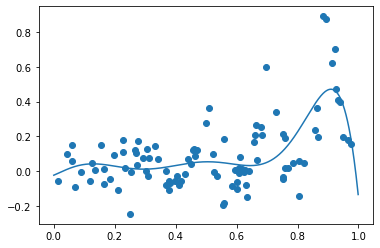

>x=0.574, f()=0.044684, actual=-0.188
>x=0.604, f()=0.029325, actual=0.054
>x=0.912, f()=0.469683, actual=0.705
>x=0.729, f()=0.077598, actual=0.442
>x=0.912, f()=0.487743, actual=0.639
>x=0.493, f()=0.046526, actual=0.305
>x=0.905, f()=0.502890, actual=0.989
>x=0.906, f()=0.541023, actual=0.655
>x=0.220, f()=0.021412, actual=-0.040
>x=0.619, f()=0.032710, actual=-0.069
>x=0.935, f()=0.497976, actual=0.352
>x=0.907, f()=0.542089, actual=0.739
>x=0.316, f()=0.011591, actual=0.045
>x=0.961, f()=0.317771, actual=-0.032
>x=0.900, f()=0.553041, actual=0.732
>x=0.901, f()=0.564088, actual=0.848
>x=0.899, f()=0.580570, actual=0.885
>x=0.770, f()=0.191843, actual=0.115
>x=0.031, f()=-0.004675, actual=0.091
>x=0.289, f()=0.004968, actual=0.099
>x=0.925, f()=0.553252, actual=0.553
>x=0.606, f()=0.026189, actual=0.166
>x=0.189, f()=0.029240, actual=-0.064
>x=0.785, f()=0.239562, actual=0.069
>x=0.277, f()=0.004362, actual=-0.157
>x=0.370, f()=0.029019, actual=0.116
>x=0.505, f()=0.076330, actual=

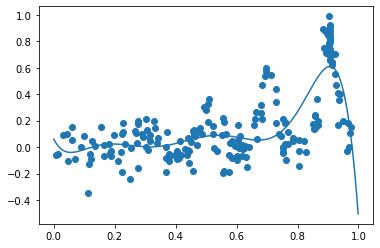

Best Result: x=0.905, y=0.989


In [6]:
# example of bayesian optimization for a 1d function from scratch
from math import sin
from math import pi
from numpy import arange
from numpy import vstack
from numpy import argmax
from numpy import asarray
from numpy.random import normal
from numpy.random import random
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from warnings import catch_warnings
from warnings import simplefilter
from matplotlib import pyplot

# objective function
def objective(x, noise=0.1):
	noise = normal(loc=0, scale=noise)
	return (x**2 * sin(5 * pi * x)**6.0) + noise

# surrogate or approximation for the objective function
def surrogate(model, X):
	# catch any warning generated when making a prediction
	with catch_warnings():
		# ignore generated warnings
		simplefilter("ignore")
		return model.predict(X, return_std=True)

# probability of improvement acquisition function
def acquisition(X, Xsamples, model):
	# calculate the best surrogate score found so far
	yhat, _ = surrogate(model, X)
	best = max(yhat)
	# calculate mean and stdev via surrogate function
	mu, std = surrogate(model, Xsamples)
	mu = mu[:, 0]
	# calculate the probability of improvement
	probs = norm.cdf((mu - best) / (std+1E-9))
	return probs

# optimize the acquisition function
def opt_acquisition(X, y, model):
	# random search, generate random samples
	Xsamples = random(100)
	Xsamples = Xsamples.reshape(len(Xsamples), 1)
	# calculate the acquisition function for each sample
	scores = acquisition(X, Xsamples, model)
	# locate the index of the largest scores
	ix = argmax(scores)
	return Xsamples[ix, 0]

# plot real observations vs surrogate function
def plot(X, y, model):
	# scatter plot of inputs and real objective function
	pyplot.scatter(X, y)
	# line plot of surrogate function across domain
	Xsamples = asarray(arange(0, 1, 0.001))
	Xsamples = Xsamples.reshape(len(Xsamples), 1)
	ysamples, _ = surrogate(model, Xsamples)
	pyplot.plot(Xsamples, ysamples)
	# show the plot
	pyplot.show()

# sample the domain sparsely with noise
X = random(100)
y = asarray([objective(x) for x in X])
# reshape into rows and cols
X = X.reshape(len(X), 1)
y = y.reshape(len(y), 1)
# define the model
model = GaussianProcessRegressor()
# fit the model
model.fit(X, y)
# plot before hand
plot(X, y, model)
# perform the optimization process
for i in range(100):
	# select the next point to sample
	x = opt_acquisition(X, y, model)
	# sample the point
	actual = objective(x)
	# summarize the finding
	est, _ = surrogate(model, [[x]])
	print('>x=%.3f, f()=%3f, actual=%.3f' % (x, est, actual))
	# add the data to the dataset
	X = vstack((X, [[x]]))
	y = vstack((y, [[actual]]))
	# update the model
	model.fit(X, y)

# plot all samples and the final surrogate function
plot(X, y, model)
# best result
ix = argmax(y)
print('Best Result: x=%.3f, y=%.3f' % (X[ix], y[ix]))

---